## Assessment Victor Onink
Here is my assessment that I completed as part of the Data Scientist job application at ABN AMRO. I looked into the type of data that was available for me to identify a person of interest (POI) from various employment data to see who warrents investigation within a company caught doing fraudulent behavior. I then conducted pre-processing to deal with data normalization and to handle missing data. Finally, I looked at how logistic regression, decision tree and K-means clustering algorithms might be employed to identify POIs. 

## Table of contents
1. [Data exploration and visualization](#Data-exploration)<br>
2. [Pre-processing](#Preprocessing)<br>
3. [Model Training - Logistic Regression](#logistic-regression)<br>
4. [Model Training - Decision Tree](#decision-tree)<br>
5. [Model Training - K-means Clustering](#k-means)<br>

In [1]:
# Useful packages
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Loading the model modules
import assessment.constants as constants
import assessment.model as model
import assessment.preprocessing as preprocessing
import assessment.visualization as visualization

## Data exploration and visualization <a class="anchor" id="Data-exploration"></a>
Prior to running any type of model training or anything, we want to have a better idea of what data is available, how this might link to the target variable of POIs and exactly how much data is missing.

In [2]:
# Loading the data
poi_data = preprocessing.read_persons_of_interest()
print('Out of {} people, {} are marked as POI. \n'.format(poi_data.poi.size, sum(poi_data.poi)))
print(poi_data)

Out of 146 people, 18 are marked as POI. 

             salary  to_messages  deferral_payments  total_payments  \
person_id                                                             
0          365788.0        807.0                NaN       1061827.0   
1          267102.0          NaN          1295738.0       5634343.0   
2          170941.0          NaN                NaN        211725.0   
3               NaN        764.0                NaN             NaN   
4          243293.0       1045.0                NaN        288682.0   
...             ...          ...                ...             ...   
141             NaN          NaN                NaN        119292.0   
142        415189.0       1892.0                NaN       1868758.0   
143        265214.0        533.0           227449.0       1092663.0   
144        278601.0        865.0                NaN        875760.0   
145        274975.0        873.0                NaN       1272284.0   

           loan_advances      bon

In [3]:
"""
Listing all the variables, and see what average values we get for each for poi == 0 and poi == 1, as well as the
number of missing data points
"""
poi_variable = poi_data.poi
for variable in poi_data.columns:
    if variable not in ['poi']:
        variable_stats = preprocessing.get_statistics_description(poi_data[variable], poi_variable)
        print("{}, for poi = {:.2f}±{:.2f}, for not poi = {:.2f}±{:.2f}, r = {:.2f}, missing = {:.2f}\n".format(variable,
                                                                                                              *variable_stats))

salary, for poi = 383444.88±278359.73, for not poi = 601152.50±2997169.37, r = -0.03, missing = 34.93

to_messages, for poi = 2417.14±1961.86, for not poi = 2007.11±2693.17, r = 0.06, missing = 41.10

deferral_payments, for poi = 519894.20±912889.50, for not poi = 1807788.85±5510228.01, r = -0.08, missing = 73.29

total_payments, for poi = 7913589.78±23965492.21, for not poi = 4605104.63±29904851.89, r = 0.04, missing = 14.38

loan_advances, for poi = 81525000.00±nan, for not poi = 28775000.00±47768000.53, r = 0.56, missing = 97.26

bonus, for poi = 2074999.94±2047437.32, for not poi = 2446776.35±11917761.23, r = -0.01, missing = 43.84

restricted_stock_deferred, for poi = nan±nan, for not poi = 166410.56±4201494.31, r = 0.00, missing = 87.67

deferred_income, for poi = -1035313.45±1334971.88, for not poi = -1170916.68±4531596.79, r = 0.01, missing = 66.44

total_stock_value, for poi = 9165670.94±13841168.37, for not poi = 6375338.54±41730841.58, r = 0.03, missing = 13.70

expenses, fo

/Users/victoronink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/victoronink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/victoronink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


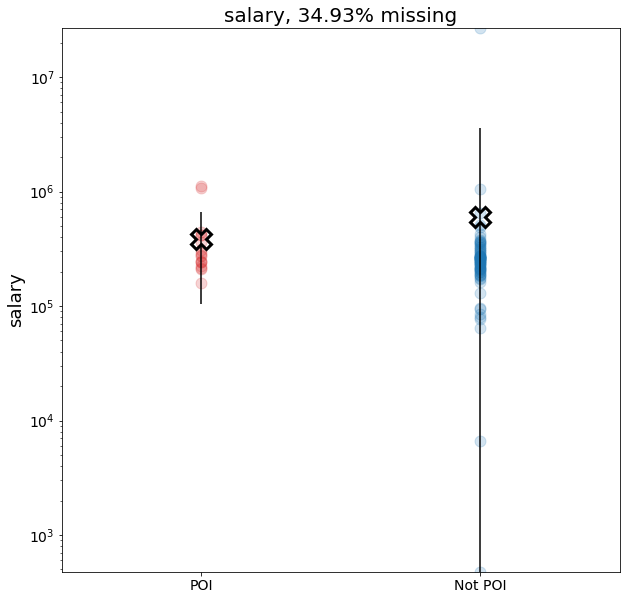

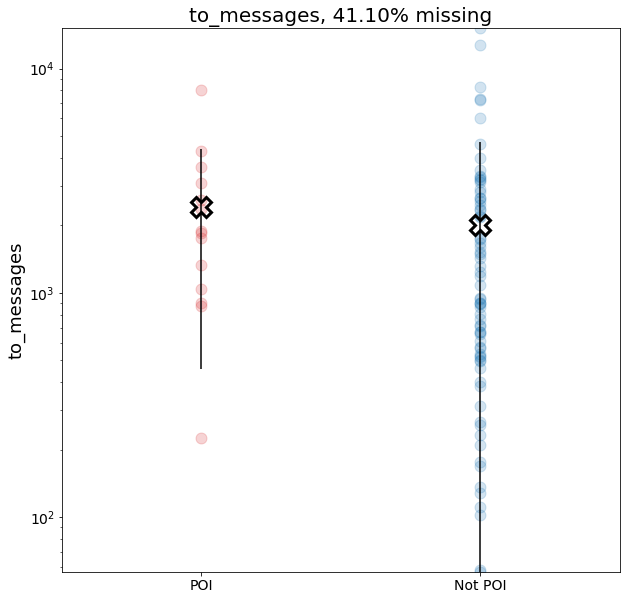

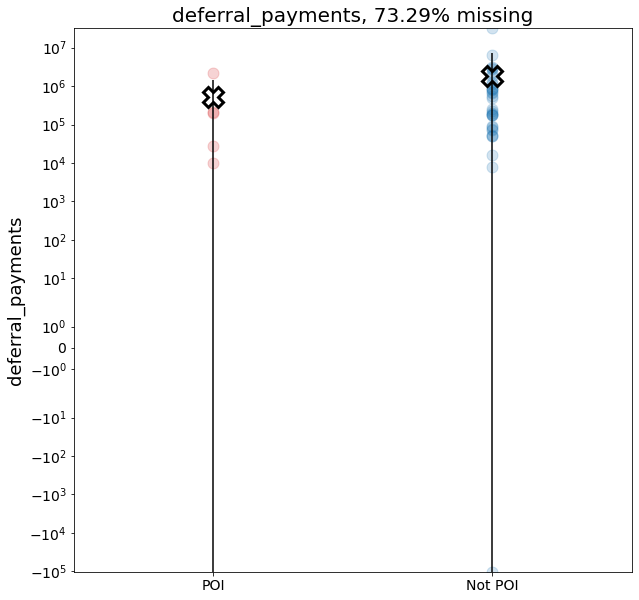

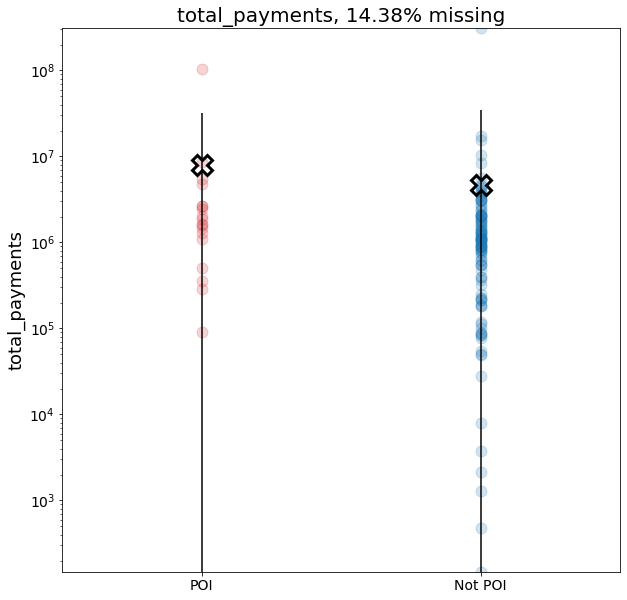

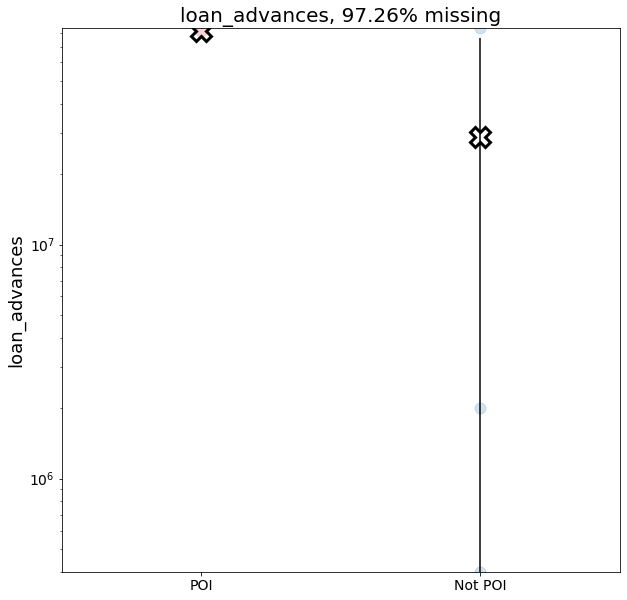

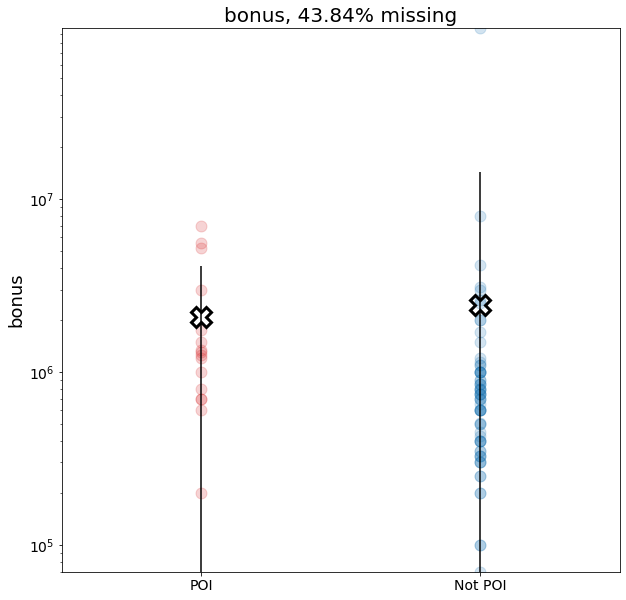

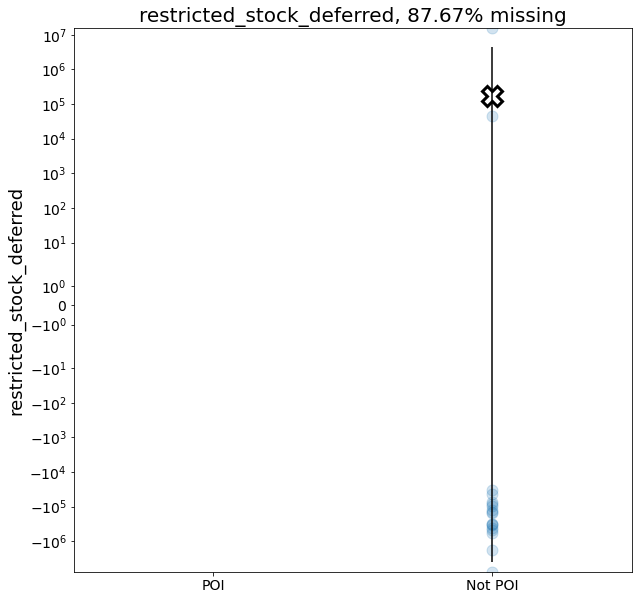

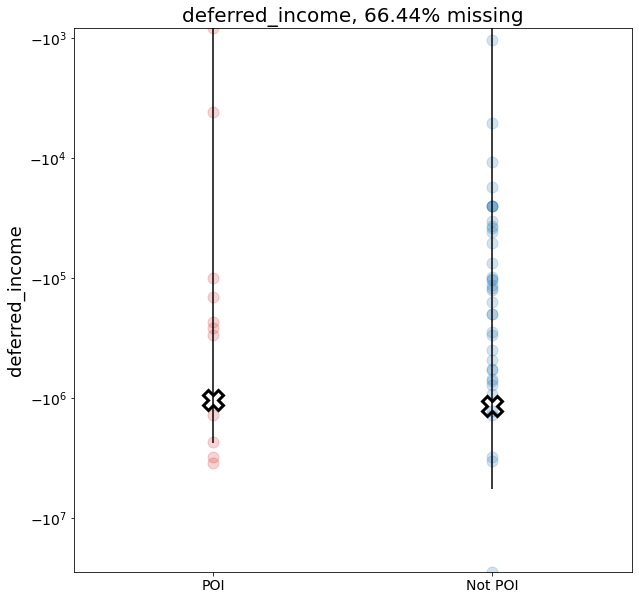

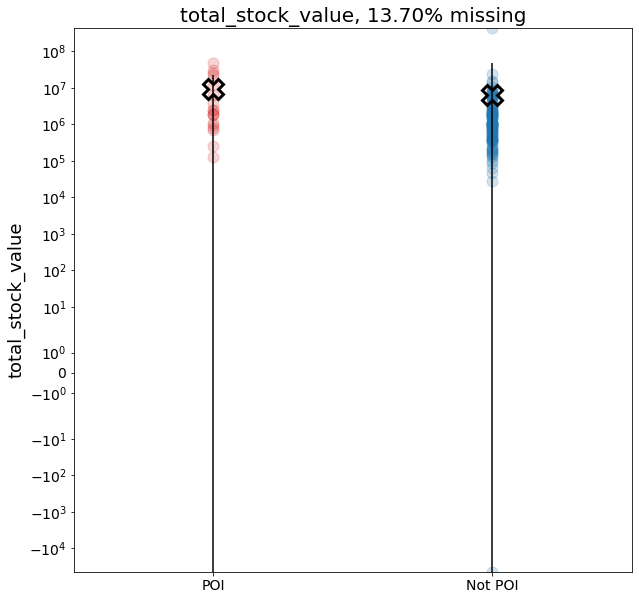

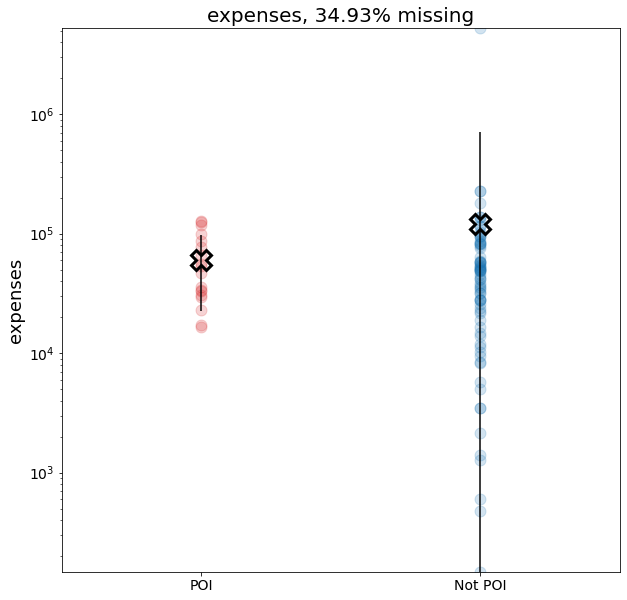

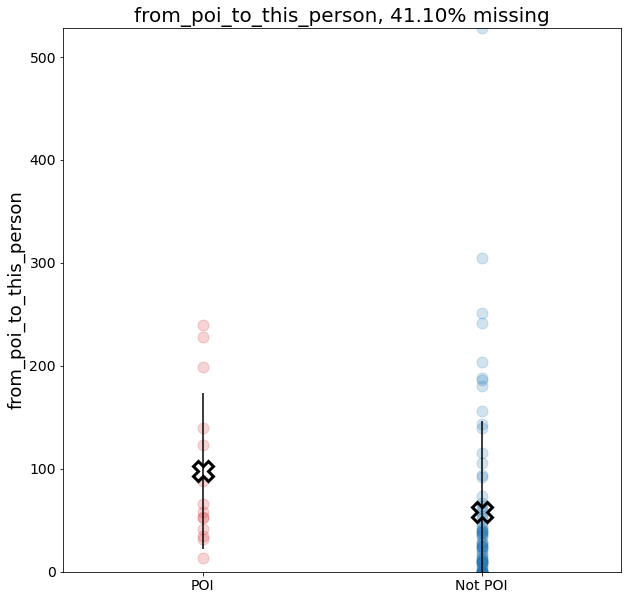

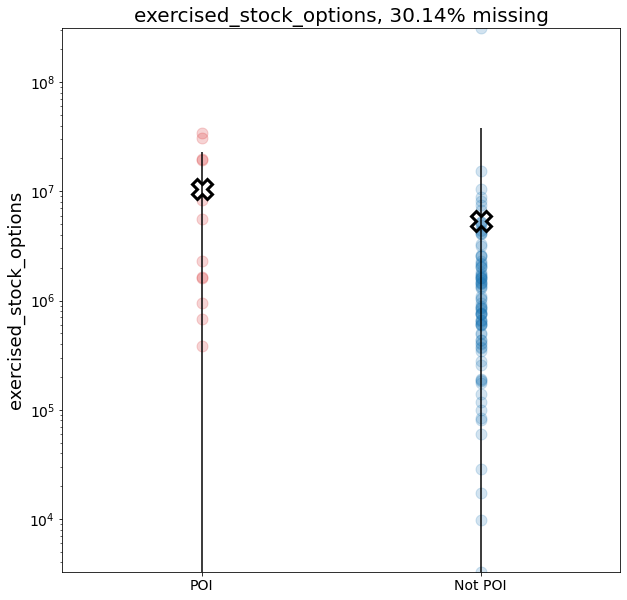

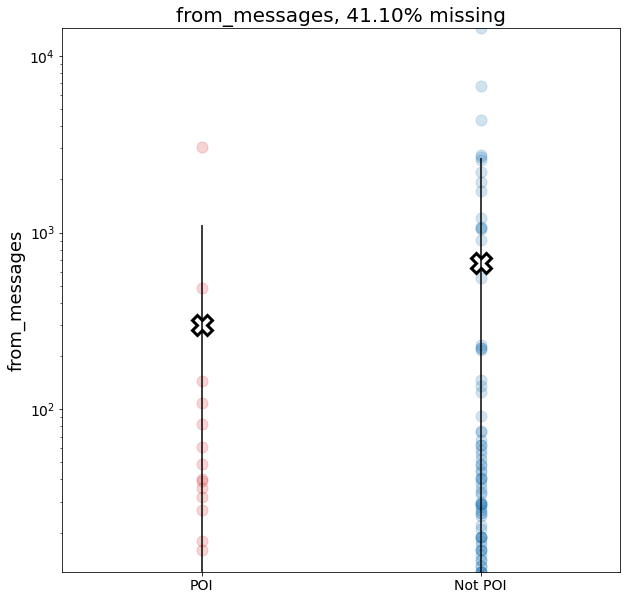

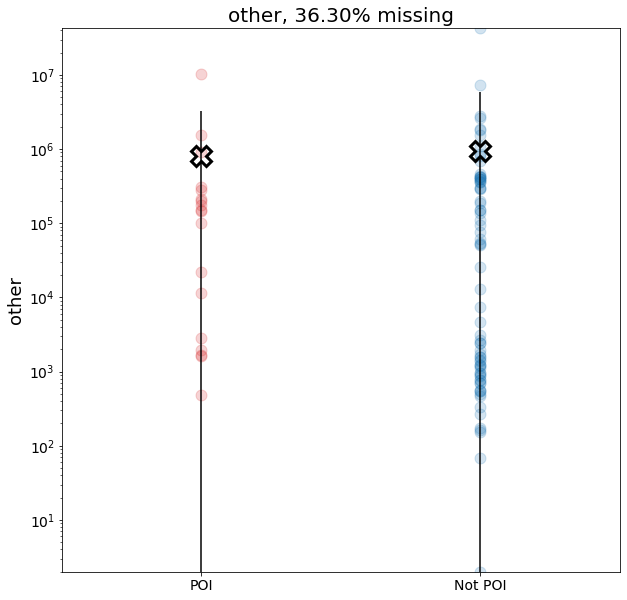

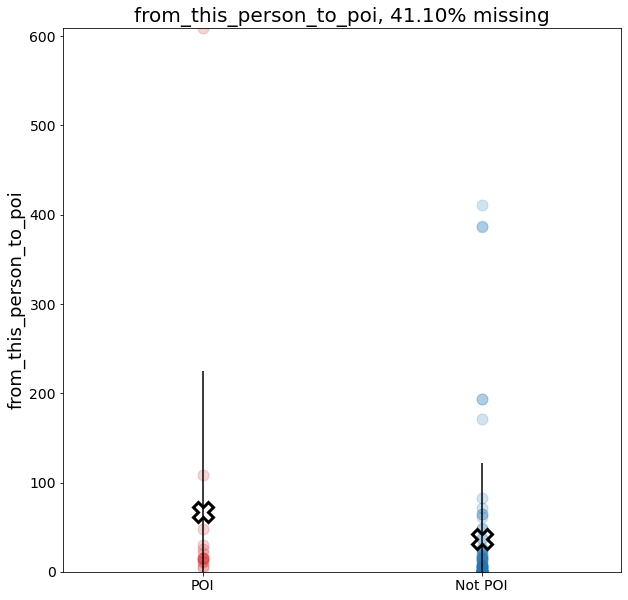

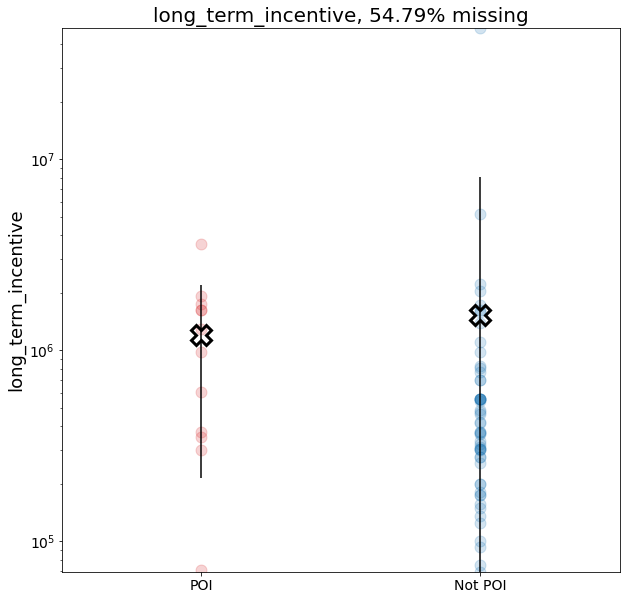

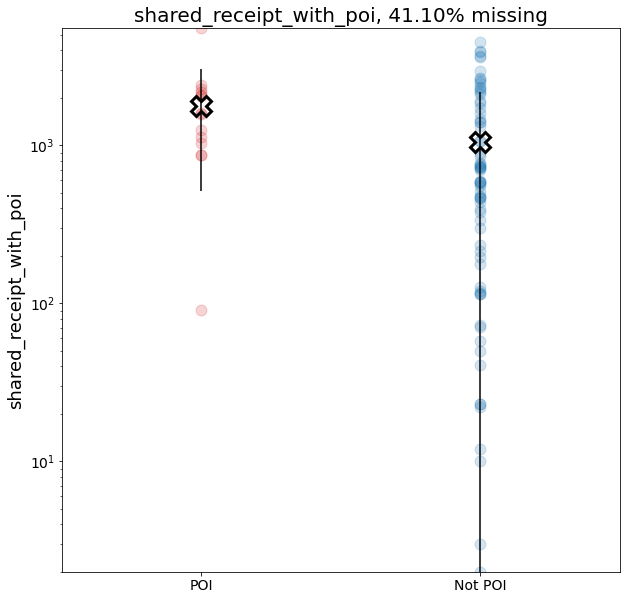

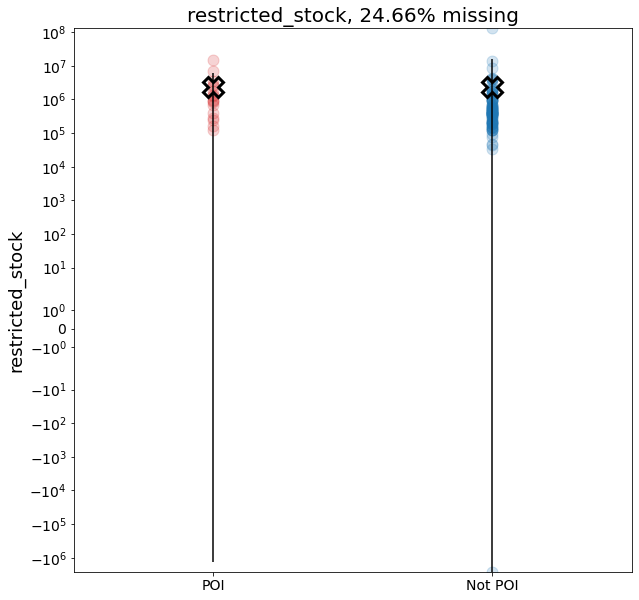

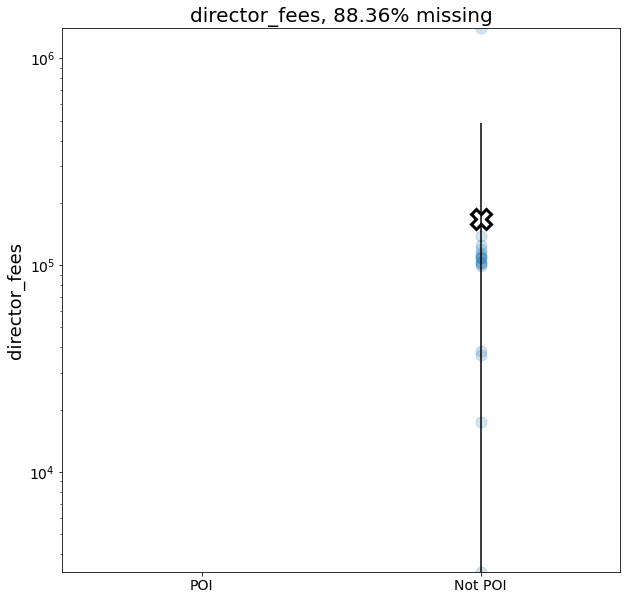

In [4]:
"""
Plotting the mean values for each variable between poi and non poi to get a better 
"""    
for variable in poi_data.columns:
    if variable not in ['poi']:
        visualization.variable_plot(variable, poi_data)


Some conclusions that we can draw from this data includes:
- There is a lot of missing data. The most complete variable (`total_stock_value`) still has over 13.7% of missing data, and unfortunately it doesn't appear that we can just always assume that a NaN value is the same as a value of 0, since e.g. there are `from_poi_to_this_person` entries that take values of 0. However, in other cases it might be more reasonable to substitute NaN values with 0, for example for variables such as `loan_advances`.
- The values generally cover very wide ranges over multiple orders of magnitude. Therefore, it is important to normalize the data beforehand. There are a number of different normalization approaches that could be used, but we shall use mean normalization with the variable mean $\mu$ and standard deviation $\sigma$:
$$ x' = \frac{x - \mu}{\sigma}$$

## Pre-processing <a class="anchor" id="Preprocessing"></a>
First, we need to decide what to do with the missing values. There are a number of options I could pursue:
1) See if it is able to get more data from the source to fill in the gaps. This might not always be possible, but any additional data I would gain via this method could be useful.

2) I could just leave out variables that have a high fraction of missing values (e.g. >50%). However, in this case this would mean I lose quite a lot of my dataset, so I would prefer not to go this route.

3) This might take more time, but based on the data I do have, I could try and predict what the missing values could be. For example, if there is a high covariance between e.g. `total_stock_value` and `exercised_stock_options` (and preferably a bunch of other variables), I could try and predict what the missing value would be based on these other variables. This comes with its own set of challenges, as any data I predict would be a proxy and not necessarily the true value, and it would require that all these other predictor variables themselves do not have a lot of missing values. However, this could be a potentially powerful technique.

4) We can just substitute all missing values for a variable with the mean/median value for that variable. This is quick to implement, but it is a strong assumption that all missing values just represent the average and it doesn't account for any coviariance that we would have with other data variables.

So, if I would have more time I would first go with option 1), and otherwise try option 3). However, this is a quick proof of concept and so I would go the faster route of either assuming NaN values represent 0 values or use the median. For each variable in the dataset, I take the following approach:
- `salary`: replace with median value
- `to_messages`: replace with median value
- `deferral_payments`: replace with 0
- `total_payments`: replace with median
- `loan_advances`: Not considered within the analysis since we only have 3/146 data points
- `bonus`: replace with median
- `restricted_stock_deferred`: Not considered within the analysis since our POI == 1 subset does not contain any people with restricted_stock_deferred.
- `deferred_income`: replace with median
- `total_stock_value`: replace with median
- `expenses`: replace with median
- `from_poi_to_this_person`: replace with median
- `exercised_stock_options`: replace with median
- `from_messages`: replace with median
- `other`: replace with median
- `from_this_person_to_poi`: replace with median
- `long_term_incentive`: replace with median
- `shared_receipt_with_poi`: replace with median
- `restricted_stock`: replace with median
- `director_fees`: Not considered within the analysis since our POI == 1 subset does not contain any people with director fees.

In [5]:
# Normalizing the data
norm_data = preprocessing.data_normalization(poi_data)

# Splitting the data into training and testing datasets
train_data, test_data, train_target, test_target = tuple(preprocessing.get_train_test_split(norm_data))


## Model Training - Logistic Regression <a class="anchor" id="logistic-regression"></a>
Essentially, what we are trying to do in this project is to answer a binary question: is someone a POI or not? As such, for each individual person we need to determine how likely it is that they are a POI, and this suggests logistic regression could be a suitable modelling approach. 

In [6]:
logistic_model = LogisticRegression().fit(train_data, train_target)

def report_LR_accuracy(logistic_model):
    training_accuracy = logistic_model.score(train_data, train_target) * 100
    test_accuracy = logistic_model.score(test_data, test_target) * 100
    str_format = training_accuracy, test_accuracy
    print('We have a training accuracy of {:.2f}% and a testing accuracy of {:.2f}%'.format(*str_format))
    
report_LR_accuracy(logistic_model)

We have a training accuracy of 90.32% and a testing accuracy of 86.36%


So, with just the default settings within the LogisticRegression class we get a training accuracy of around 90%, and a testing accuracy of 81 - 86%. This is already a very good start, but we can play around with some parameters to see if we can increase this.

In [14]:
# For example, we can affect the regularization strength, where the default value is C=1.0. Smaller values increase 
# the regularization (and reduce overfitting) whereas larger values increase it.
for C in [0.01, 0.5, 1, 5, 10, 30]:
    logistic_model = LogisticRegression(C=C, max_iter=200).fit(train_data, train_target)
    print('C = {}'.format(C))
    report_LR_accuracy(logistic_model)
    print('\n')
    

C = 0.01
We have a training accuracy of 87.90% and a testing accuracy of 86.36%


C = 0.5
We have a training accuracy of 88.71% and a testing accuracy of 86.36%


C = 1
We have a training accuracy of 90.32% and a testing accuracy of 86.36%


C = 5
We have a training accuracy of 92.74% and a testing accuracy of 86.36%


C = 10
We have a training accuracy of 93.55% and a testing accuracy of 86.36%


C = 30
We have a training accuracy of 92.74% and a testing accuracy of 81.82%




In [16]:
# We can also play around with the type of regularization we want to include, for example:
# - no regularization
# - a L2 penalty term
for penalty in ['l2', 'none']:#['none', 'l2', 'l1', 'elasticnet']:
    logistic_model = LogisticRegression(penalty=penalty, max_iter=500).fit(train_data, train_target)
    print('Penalty = {}'.format(penalty))
    report_LR_accuracy(logistic_model)
    print('\n')

Penalty = l2
We have a training accuracy of 90.32% and a testing accuracy of 86.36%


Penalty = none
We have a training accuracy of 93.55% and a testing accuracy of 81.82%




By playing around with hyperparameters and regularization methods, we can try to increase the the model accuracy. For example, in this case C = 5 - 10 (so weaker regularization) led to a higher testing accuracy than the default C = 1. However, applying no regularization at all resulted in poorer testing accuracy despite the training accuracy being a bit higher. This is a clear indication that we are overfitting. Weaker regularization also required additional iterations to reach a stable solution, and this makes it more computationally expensive to run such models.

We can continue to play around with the model parameters, but overall it appears we can get a logistic regression model that works with up to ~86% accuracy in identifying poi's in the given dataset. 

## Model Training - Decision Tree <a class="anchor" id="decision-tree"></a>
Another commonly used algorithm for this kind of decision making (as in, is someone a POI or not) is the decision tree. The advantage of the decision tree is that it can generally be easier to interpret the developed model, as it is possible to see the internal decision logic.

In [9]:
tree_model = DecisionTreeClassifier().fit(train_data, train_target)

def report_tree_accuracy(tree_model):
    training_accuracy = metrics.accuracy_score(train_target, tree_model.predict(train_data)) * 100
    test_accuracy = metrics.accuracy_score(test_target, tree_model.predict(test_data)) * 100
    str_format = training_accuracy, test_accuracy
    print('We have a training accuracy of {:.2f}% and a testing accuracy of {:.2f}%'.format(*str_format))

report_tree_accuracy(tree_model)

We have a training accuracy of 100.00% and a testing accuracy of 68.18%


In short, we get a perfect training accuracy, but the testing accuracy with just the default tree settings is lower than we got with logistic regression. However, we can again start modifying the decision tree hyperparameters to try and improve the model performance.

In [10]:
# First, we can compare what happens when we change the selection criterion from the default "gini" criterion to the  
# "entropy" criterion.
for criterion in ['gini', 'entropy']:
    tree_model = DecisionTreeClassifier(criterion=criterion).fit(train_data, train_target)
    print('Criterion = {}'.format(criterion))
    report_tree_accuracy(tree_model)
    print('\n')

Criterion = gini
We have a training accuracy of 100.00% and a testing accuracy of 68.18%


Criterion = entropy
We have a training accuracy of 100.00% and a testing accuracy of 68.18%




In [11]:
# Next, we can set a maximum depth for the decision tree, where a very low depth can result in overfitting, while 
# higher (or unrestrained) max_depth limits can result in overfitting
for max_depth in [1, 3, 5, 10, 15, None]:
    tree_model = DecisionTreeClassifier(max_depth=max_depth).fit(train_data, train_target)
    print('max_depth = {}'.format(max_depth))
    report_tree_accuracy(tree_model)
    print('\n')

max_depth = 1
We have a training accuracy of 87.90% and a testing accuracy of 86.36%


max_depth = 3
We have a training accuracy of 92.74% and a testing accuracy of 77.27%


max_depth = 5
We have a training accuracy of 99.19% and a testing accuracy of 63.64%


max_depth = 10
We have a training accuracy of 100.00% and a testing accuracy of 68.18%


max_depth = 15
We have a training accuracy of 100.00% and a testing accuracy of 68.18%


max_depth = None
We have a training accuracy of 100.00% and a testing accuracy of 72.73%




So in this case, we could see that the criterion doesn't seem to affect the testing accuracy much (the somewhat random nature of the decision tree means the testing accuracy will vary somewhat between runs). Meanwhile, restricting the max_depth can increase the testing accuracy, as it prevents the overfitting of data. It would also be possible to run an entire ensemble of decision tree models (commonly referred to as a random forest approach), but given the relatively limited dataset it is unsure whether this would strongly increase the model performance.

In the end, there doesn't seem to be a whole lot of difference between using the decision tree and logistic regression approaches to tackle this particular project. In this case, the model would just be used to give an initial indication of people of interest within the fraudulant company, and additional investigation will eventually condemn or acquit them. However, if the model predictions were an important component of the judicial proceedings, a decision tree approach might be more suitable, as it allows users to better comprehend and explain the decision processes that led to the final indication of whether someone is a poi or not.

## Model Training - K-means Clustering <a class="anchor" id="k-means"></a>
One final way of approaching the problem is that we can see the company as consisting of clusters of employees, where these clusters might indicate similar job descriptions or people in different departments that might have to collaborate often. Therefore, it might be that some of these clusters are more likely to contain people of interest than others, and therefore identify who warrents further investigation regarding fraud in the company.

One clustering algorithm is the K-Means algorithm, which distributes data points into `n_clusters` such as to mimize the distance to the cluster centroids for all the data points within a cluster. Then, we can reduce the dimensionality of the data from 17-dimensional space to 2-dimensional in order to visualize the clusters. In this case we are largely interested in investigating whether such POI-heavy clusters exist, so we do not separate the data into training and test subsets and just consider all data as a whole.

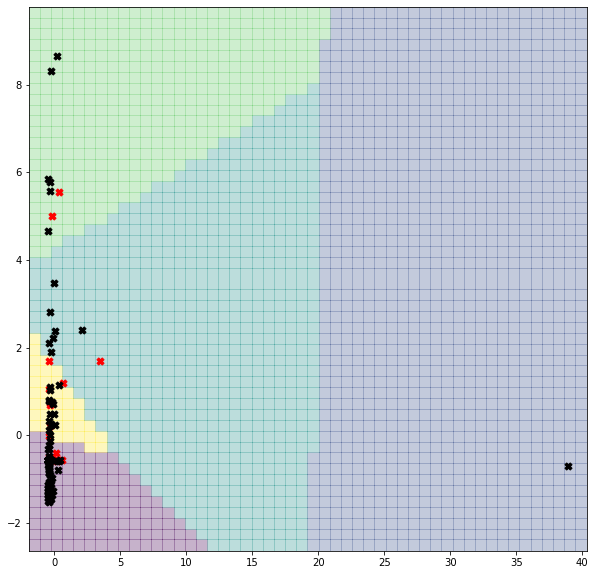

In [12]:
# Getting the normalized data
norm_data = preprocessing.data_normalization(poi_data)
poi_labels = norm_data.poi
norm_data = norm_data.drop(columns=['poi'])

# Reducing the data to two dimensions so we can later visualize this
reduced_data = PCA(n_components=2).fit_transform(norm_data)

# Running the K-means algorithm
kmeans = KMeans(init='k-means++', n_clusters=5).fit(reduced_data)

# Creating a figure that shows the decision boundaries, where we first need to get the domain of the figure and
# then determine the domains of these clusters
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
X, Y = np.meshgrid(np.linspace(x_min, x_max, num=50), np.linspace(y_min, y_max, num=50))

Z = kmeans.predict(np.c_[X.flatten(), Y.flatten()])
Z = Z.reshape(X.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.pcolormesh(X, Y, Z, cmap='viridis', alpha=0.3, shading='auto')

# Plotting the POI points in red
ax.scatter(reduced_data[:, 0][poi_labels], reduced_data[:, 1][poi_labels], c='red', marker='X',s=50)
ax.scatter(reduced_data[:, 0][poi_labels == False], reduced_data[:, 1][poi_labels == False], c='black', marker='X',s=50)

In the current form, it doesn't appear that this approach is very promising, as there doesn't seem to be a clear cluster of POI's (red labels) that is distinct from the other employees (black labels) in the country. One thing that can be attempted is to rerun the analysis without employee 103, which is the large outlier we can see in the figure above in the bottom right corner.  

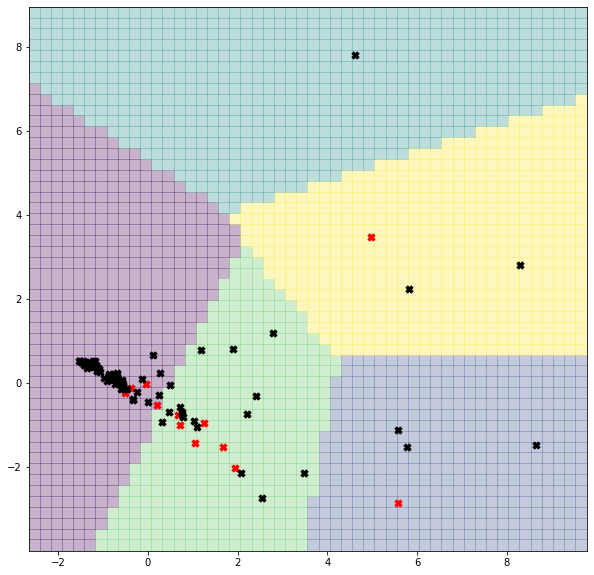

In [17]:
# Getting the normalized data
norm_data = preprocessing.data_normalization(poi_data)
norm_data = norm_data.drop(index=[103])
poi_labels = norm_data.poi
norm_data = norm_data.drop(columns=['poi'])

# Reducing the data to two dimensions so we can later visualize this
reduced_data = PCA(n_components=2).fit_transform(norm_data)

# Running the K-means algorithm
kmeans = KMeans(init='k-means++', n_clusters=5).fit(reduced_data)

# Creating a figure that shows the decision boundaries, where we first need to get the domain of the figure and
# then determine the domains of these clusters
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
X, Y = np.meshgrid(np.linspace(x_min, x_max, num=50), np.linspace(y_min, y_max, num=50))

Z = kmeans.predict(np.c_[X.flatten(), Y.flatten()])
Z = Z.reshape(X.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.pcolormesh(X, Y, Z, cmap='viridis', alpha=0.3, shading='auto')

# Plotting the POI points in red
ax.scatter(reduced_data[:, 0][poi_labels], reduced_data[:, 1][poi_labels], c='red', marker='X',s=50)
ax.scatter(reduced_data[:, 0][poi_labels == False], reduced_data[:, 1][poi_labels == False], c='black', marker='X',s=50)

Removing the outlier does show that there is some cluster formation when the data is reduced down to two dimensions, but there is not a clear indication that there is any one cluster that predominantly consists of POI's. In this case, the entire dataset was reduced to two dimensions in order to be able to visualize the clusters, but in principle this isn't necessary for this approach and it could be that distinct clusters do form in higher-dimensional datasets. However, compared to the logistic regression and decision tree approaches, the K-means clustering approach appears less promising for further development in this particular use case.